In [2]:
import requests
import json 
import os
from datetime import date, datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from wordcloud import WordCloud

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import collections


Достаю 4 параметра:
    1) пол
    2) город
    3) возраст
    4) открытый/закрытый профиль

In [388]:
def make_csv(line):
    headline = 'post_type\tpost_id\tauthor_id\tname\tsurname\tsex\tcity +\
    \tage\tprofile\ttext\tlength\n'
    if not os.path.exists('meta.csv'):
        with open('meta.csv', 'w', encoding="utf-8") as f:
            f.write(headline)
    with open('meta.csv', 'a', encoding='utf-8') as f:
        f.write(line)


def make_line(ptype, pid, au, name, surname, sex, city, age, profile,
              text, length):
    draft_line = '%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%d\t\n'
    line = draft_line % (ptype, pid, au, name, surname, sex, city, age,
                         profile, text, length)
    return line


In [389]:
def count_age(bdate):
    today = date.today()
    age = today.year - bdate.year
    if today.month < bdate.month:
        age -= 1
    elif today.month == bdate.month and today.day < bdate.day:
        age -= 1
    return age


In [396]:
def get_info(author_id, token, version):
    params = {'access_token': token, 'v': version,
              'v': '5.95', 'user_ids': author_id,
              'fields': 'city,sex,first_name,last_name,bdate'}
    req = requests.get('https://api.vk.com/method/users.get',
                       params=params)
    data = req.text
    data = json.loads(data)
    items = data['response'][0]
    name = items['first_name']
    surname = items['last_name']
    try:
        profile = items['is_closed']
    except KeyError:
        profile = None
    if profile == 'False':
        profile = 'open'
    else:
        profile = 'closed'
    sex = items['sex']
    if sex == 1:
        sex = 'female'
    elif sex == 2:
        sex = 'male'
    else:
        sex = None
    try:
        city = items['city']['title']
    except KeyError:
        city = None
    try:
        bday = items['bdate']
    except KeyError:
        bday = None
        age = None
    else:
        try:
            day, month, year = bday.split('.')
        except ValueError:
            age = None
        else:
            time_string = day + '/' + month + '/' + year
            bdate = datetime.strptime(time_string, '%d/%m/%Y')
            age = count_age(bdate)
    return name, surname, sex, city, age, profile


In [397]:
def com_info(post_id, community_id, token, count, version, offsets):
    for off in offsets:
        params = {'access_token': token, 'v': version,
                  'owner_id': community_id, 'post_id': post_id,
                  'count': count, 'offset': off}
        req = requests.get('https://api.vk.com/method/wall.getComments',
                           params=params)
        data = req.text
        data = json.loads(data)
        items = data['response']['items']
        if not items:
            break
        for item in items:
            ptype = 'comment'
            try:
                text = item['text'].lower()
                text = text.split('\n')  # чистим текст комментария
                text = ' '.join(text)
                text = re.sub(r'[-.""?!_(),:;1234567890a-zA-Z]', '', text)
                text = re.sub('[^\s\w-]', '', text)  # убираем смайлики
                text = re.sub('  ', ' ', text)
                length = len(text.split(' '))
            except KeyError:
                text = None
                length = 0
            comment_id = item['id']
            post_comment_id = '%s_%s' % (post_id, comment_id)
            try:
                au_comment_id = item['from_id']
            except KeyError:
                break
            else:
                if str(au_comment_id).startswith('-') or length == 0:
                    break
                else:
                    (f_name, l_name, sex, city, age, profile) = get_info(
                        au_comment_id, token, version)
                    line = make_line(ptype, post_comment_id, au_comment_id,
                                     f_name, l_name, sex, city,
                                     age, profile, text, length)
                    make_csv(line)


In [398]:
def get_posts(community, count, token, offsets, version):
    for off in offsets:
        params = {'access_token': token, 'v': version,
                  'count': count, 'domain': community, 'offset': off}
        req = requests.get('https://api.vk.com/method/wall.get',
                           params=params)
        data = req.text
        data = json.loads(data)
        items = data['response']['items']
        for item in items:
            community_id = item['owner_id']
            ptype = item['post_type']
            post_id = item['id']  # в csv "прикрпеляем" к нему комментарии
            text = item['text'].lower()
            text = text.split('\n')  # сразу чистим текст
            text = ' '.join(text)
            text = re.sub(r'[-.""?!_(),:;1234567890a-zA-Z]', '', text)
            text = re.sub('[^\s\w-]', '', text)  # убираем смайлики
            text = re.sub('  ', ' ', text)
            length = len(text.split(' '))
            try:
                author_id = item['signer_id']
            except KeyError:
                author_id = community_id
            if author_id != community_id:
                if length > 0:  # нас не интересует пост из смайликов
                    (name, surname, sex, city, age, profile) = get_info(
                        author_id, token, version)
                    info_post = make_line(ptype, post_id, author_id,
                                          name, surname, sex, city,
                                          age, profile, text, length)
                    make_csv(info_post)
                    com_info(post_id, community_id, token, count, version,
                             offsets)


community = 'proekt_ne_gotov'
token = '9356763093567630935676301d933c29ad\
9935693567630cf9bffcfc72e1f694032d1ff'
offsets = [0, 100, 200]
version = '5.95'
count = 100
get_posts(community, count, token, offsets, version)


0
100
200


График 1: как длина поста соотносится со средней длиной комментариев к нему:

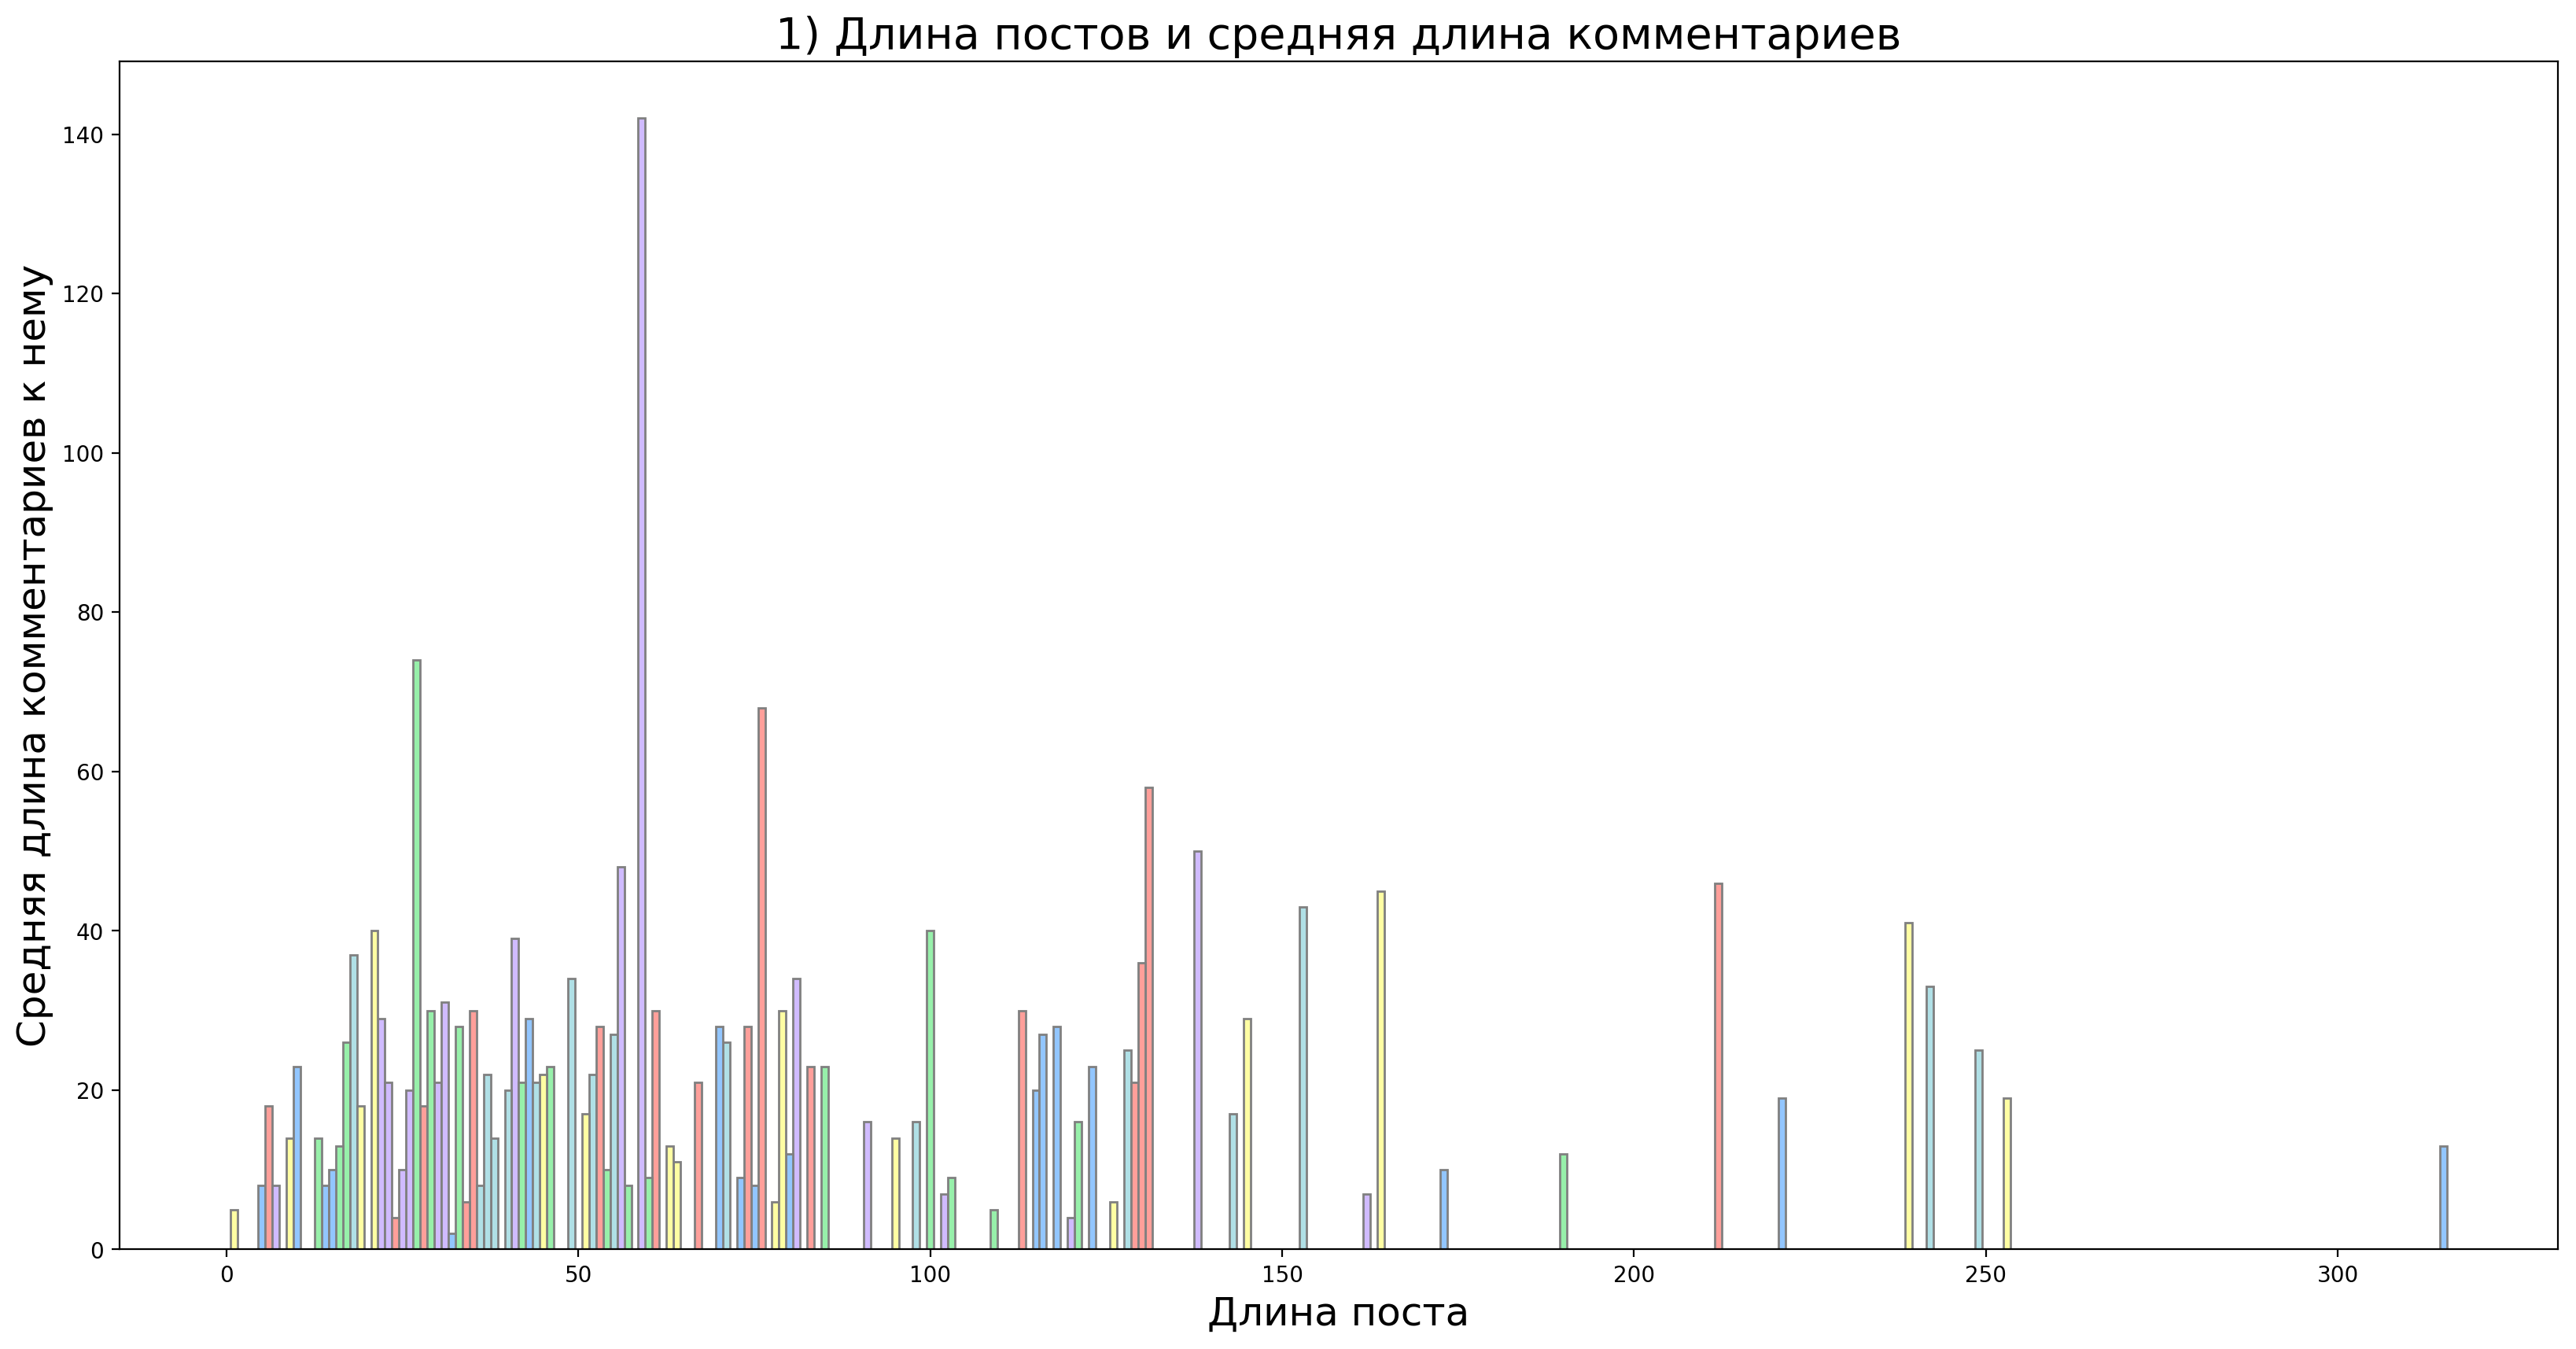

In [7]:
def graph1():
    avrg_len = {}
    with open('meta.csv', 'r', encoding="utf-8") as f:
        table = f.read()
    lines = table.split('\n')
    for line in lines[1:]:  # убираем строку заголовков
        if line.split('\t')[0] == 'post':
            k = 0
            sum_length = 0
            i = lines.index(line)  # номер строки в таблице
            post_id = line.split('\t')[1]
            post_length = int(line.split('\t')[10])
            for line in lines[i+1:]:
                try:
                    cell_id = line.split('\t')[1].split('_')[0]
                except:
                    IndexError
                if cell_id == post_id:
                    k += 1
                    try:
                        length = int(line.split('\t')[10])
                        sum_length += length
                    except:
                        IndexError
            if k != 0:
                sum_length = round(sum_length/k)
                avrg_len[post_length] = sum_length
    # сторим график
    colors = sns.color_palette('pastel')
    title = '1) Длина постов и средняя длина комментариев'
    y = avrg_len.values()
    x = avrg_len.keys()
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(x, y, color=colors, edgecolor='gray', width=1)
    plt.ylabel('Средняя длина комментариев к нему',  fontsize=18)
    plt.xlabel('Длина поста',  fontsize=18)
    plt.title(title, fontsize=20)
    plt.savefig(title)
    plt.show()

graph1()


Собираем тексты всех постов и комментариев в один файл, чтобы потом вытащить 20 самых частотных слов

In [8]:
def collect_texts():
    with open('meta.csv', 'r', encoding="utf-8") as f:
        table = f.read()
    lines = table.split('\n')
    with open('texts_plain.txt', 'w', encoding="utf-8") as f:
        for line in lines[1:100]:
            text = line.split('\t')[9]
            f.write(text + ' ')


collect_texts()


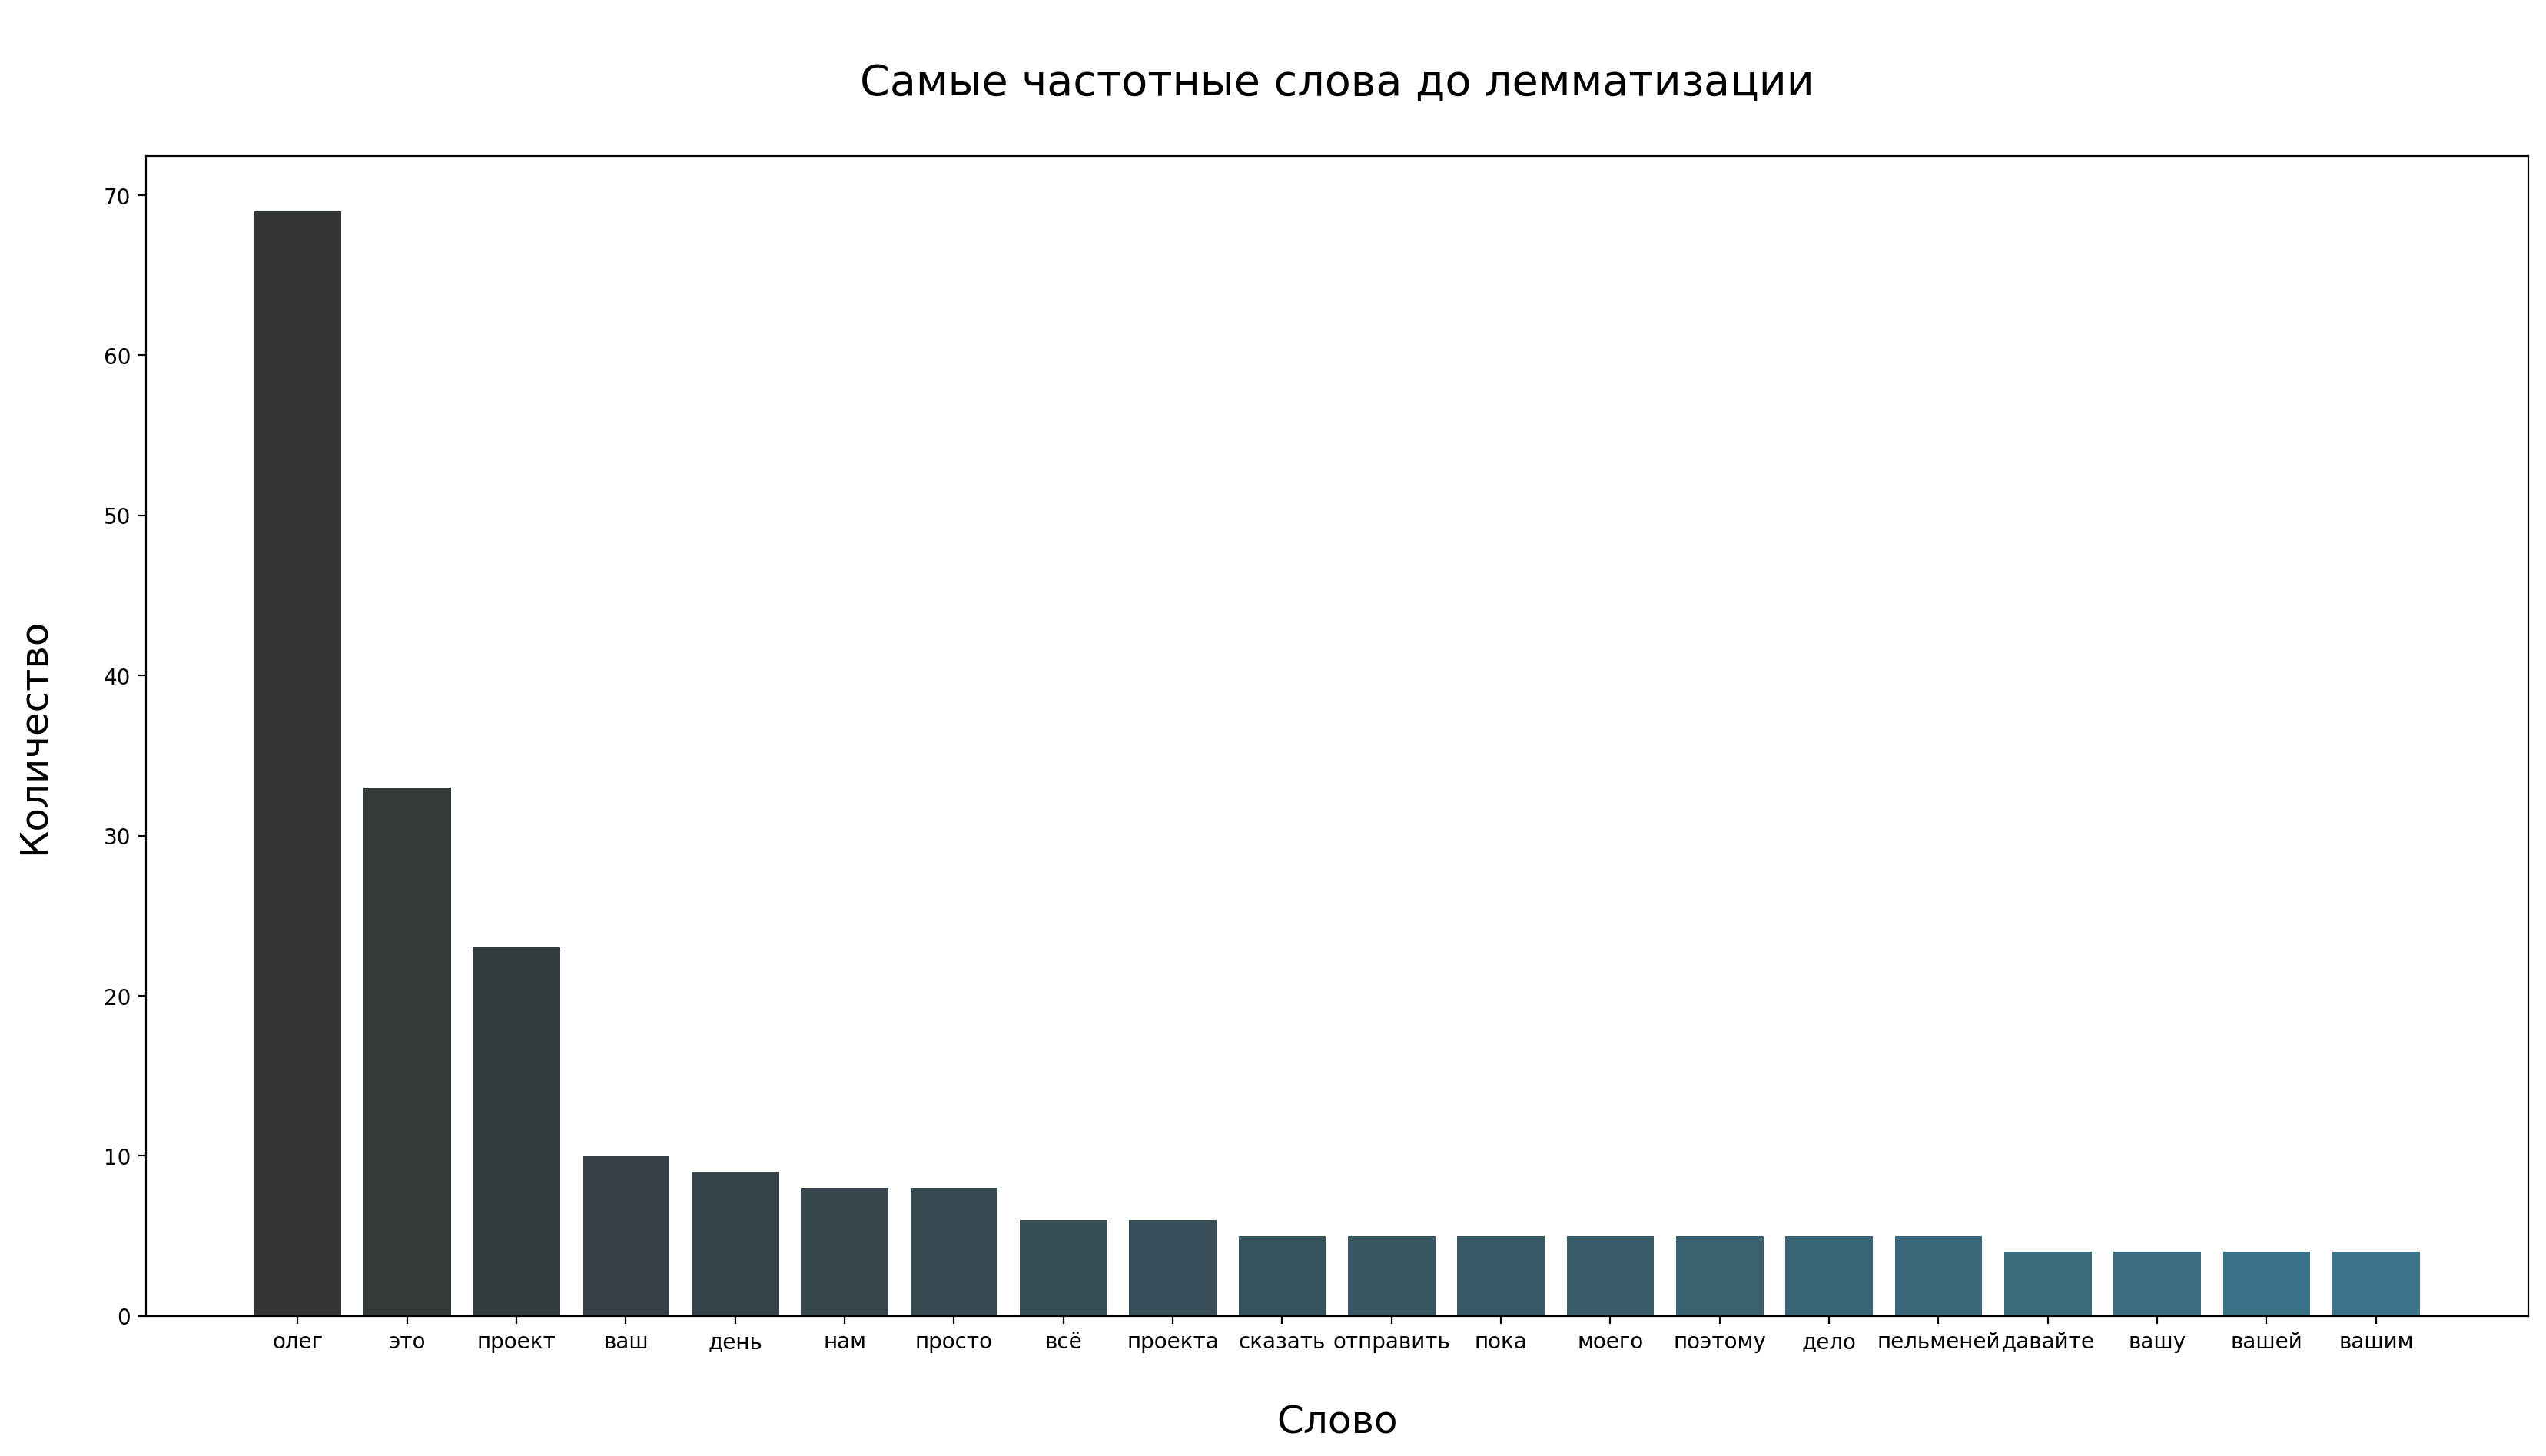

In [9]:
def freq_plain():
    with open('texts_plain.txt', 'r', encoding="utf-8") as f:
        words = f.read().split(' ')
    russian_sw = stopwords.words("russian")
    words = [word for word in words if word not in russian_sw and word != '']
    freq_plain = collections.Counter(words).most_common(20)
    freq_plain = dict(freq_plain)
    freq_plain = {w: freq_plain[w] for w in freq_plain}
    # строим график
    plain_nums = [w[1] for w in freq_plain.items()]
    plain_labs = [word for word in freq_plain]
    x = range(len(plain_labs))
    colors = sns.color_palette('GnBu_d', max(plain_nums))
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(plain_labs, plain_nums, color=colors)

    title = '\nСамые частотные слова до лемматизации\n'
    plt.title(title, fontsize=20)
    plt.ylabel('Количество\n',  fontsize=18)
    plt.xlabel('\nСлово',  fontsize=18)
    plt.savefig(title)
    plt.show()


freq_plain()


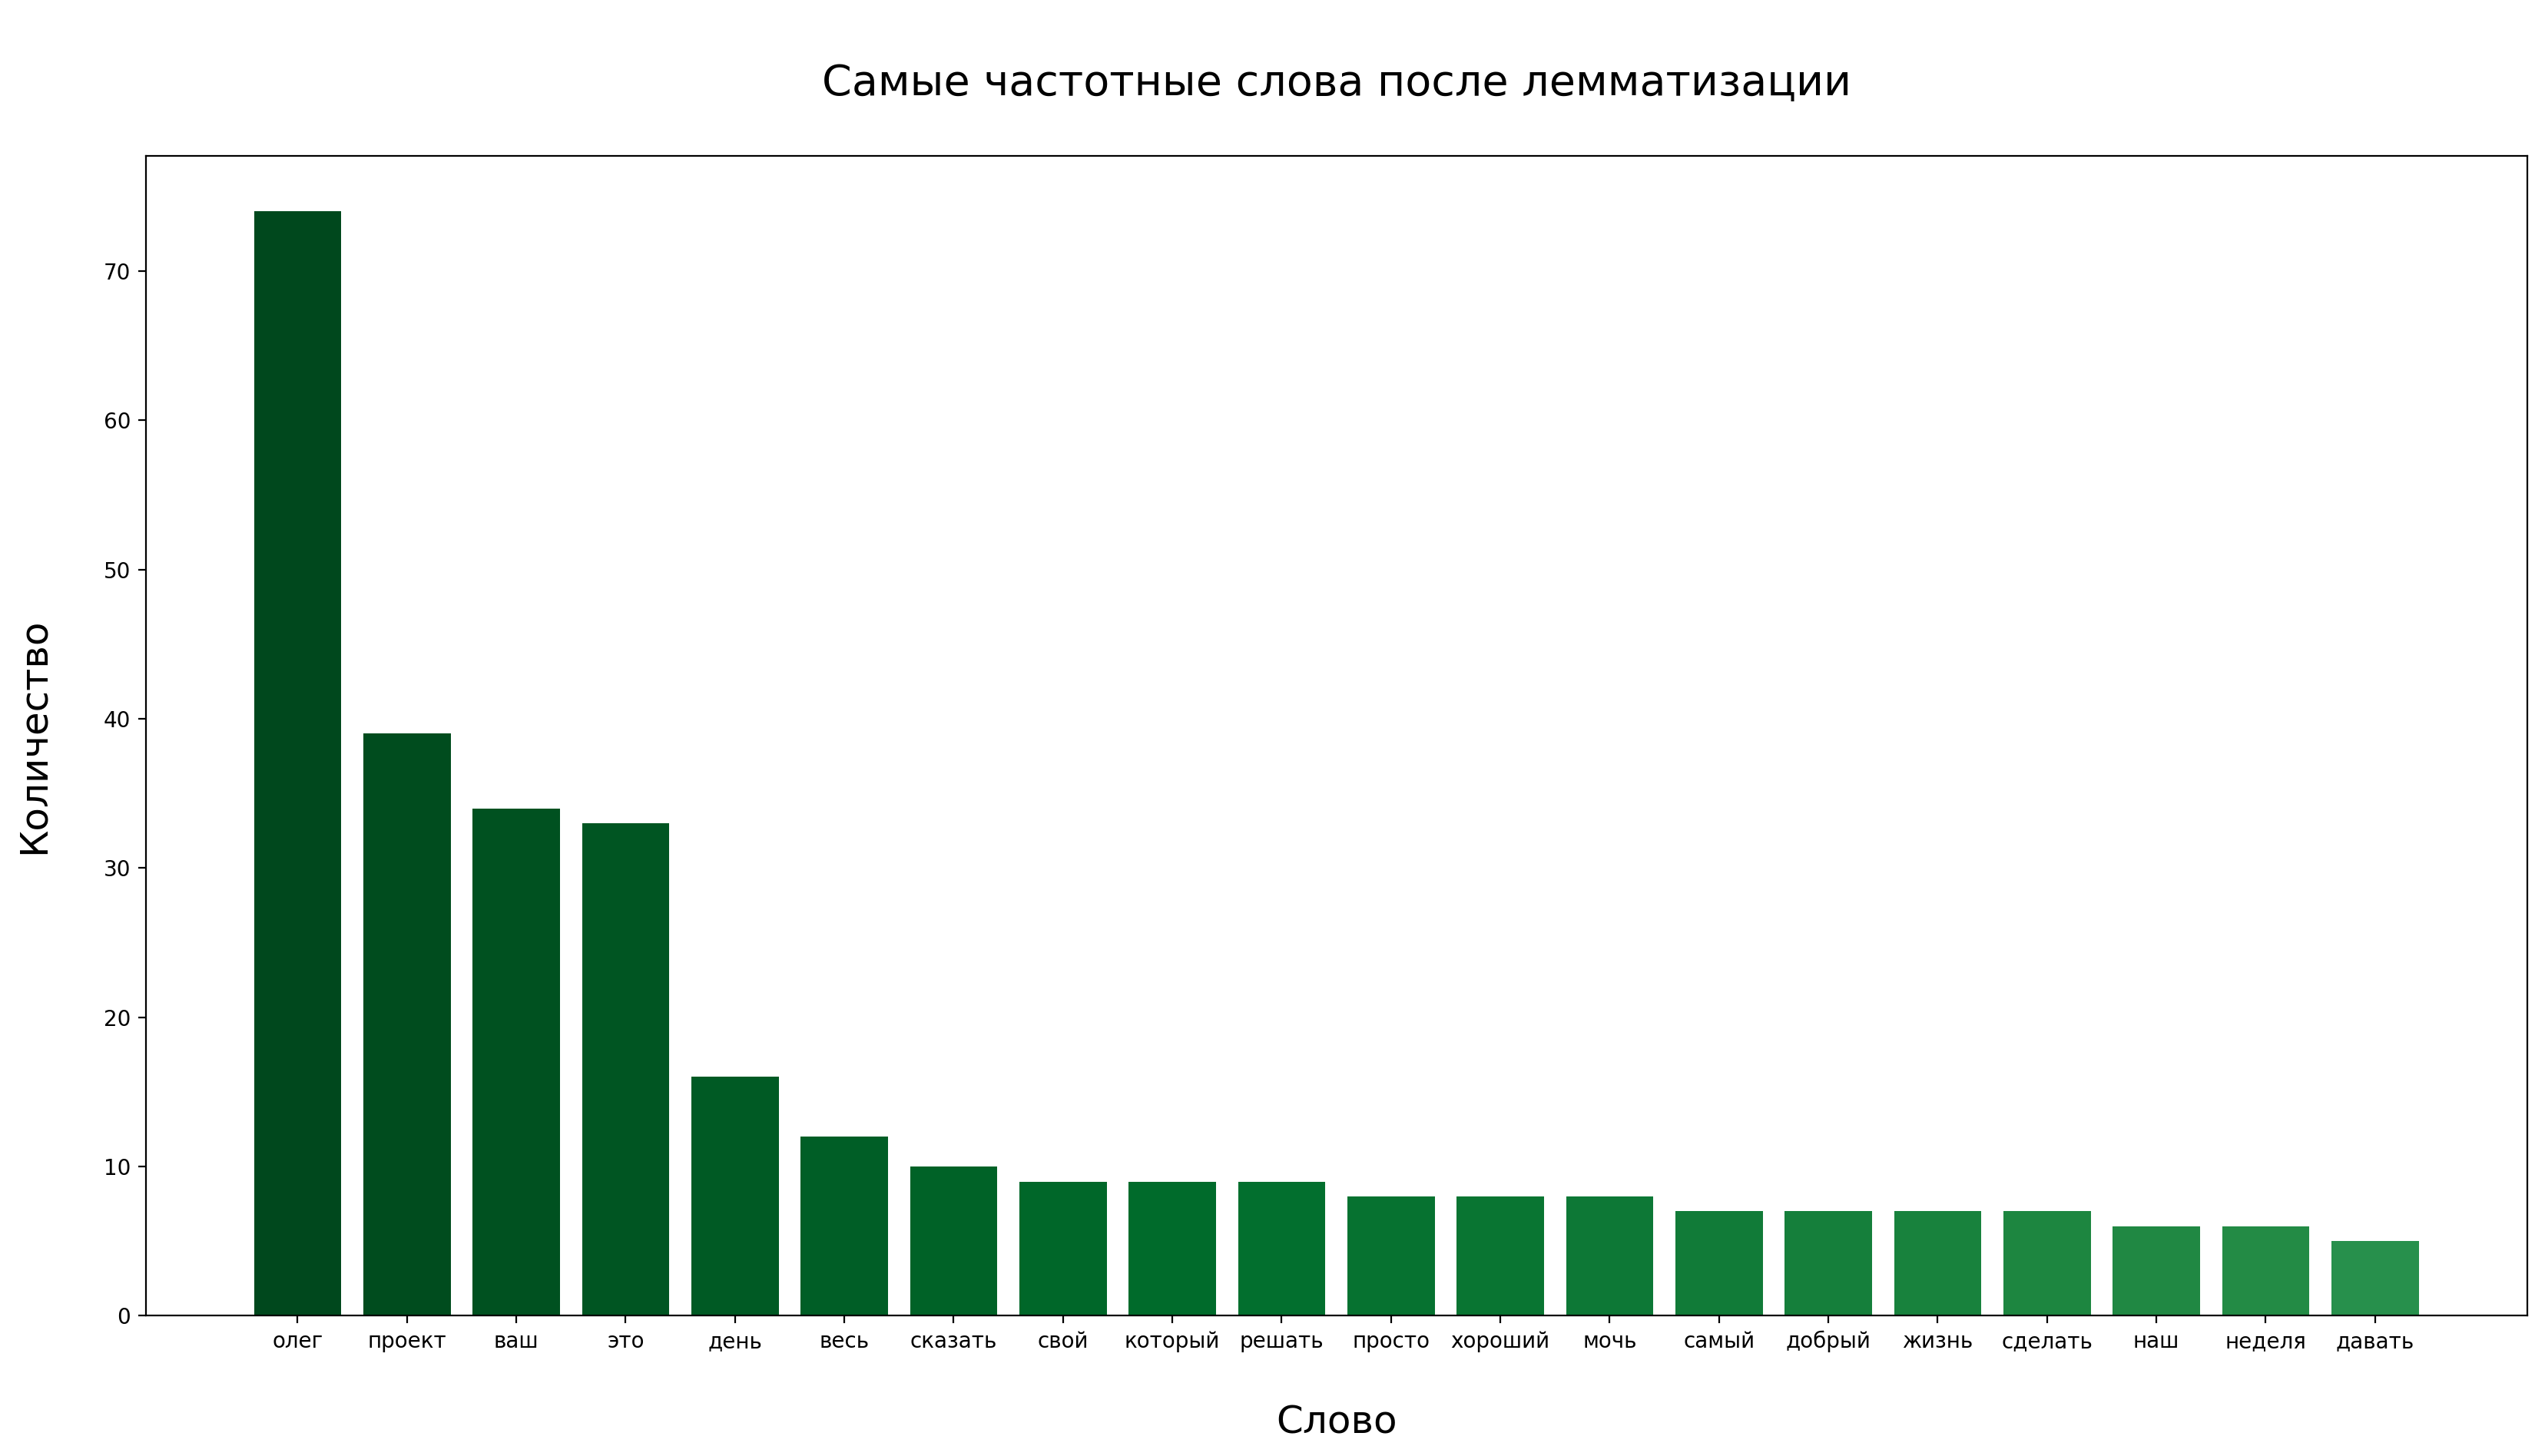

In [10]:
def freq_mystem():
    mystem = Mystem()
    russian_sw = stopwords.words("russian")
    with open('texts_plain.txt', 'r', encoding="utf-8") as f:
        text = f.read()
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_sw\
              and token != '' and token != ' '\
              and token.strip() not in punctuation]
    with open('texts_mystem.txt', 'w', encoding="utf-8") as f:
        for token in tokens:
            f.write(token + ' ')
    freq_mystem = collections.Counter(tokens).most_common(20)
    freq_mystem = dict(freq_mystem)
    freq_mystem = {w: freq_mystem[w] for w in freq_mystem}
    # строим график
    mystem_nums = [w[1] for w in freq_mystem.items()]
    mystem_labs = [word for word in freq_mystem]
    x = range(len(mystem_labs))
    colors = sns.color_palette('BuGn_r', max(mystem_nums))
    plt.figure(figsize=(20, 10), dpi=200)
    plt.bar(mystem_labs, mystem_nums, color=colors)

    title = '\nСамые частотные слова после лемматизации\n'
    plt.title(title, fontsize=20)
    plt.ylabel('Количество\n',  fontsize=18)
    plt.xlabel('\nСлово',  fontsize=18)
    plt.savefig(title)
    plt.show()

freq_mystem()


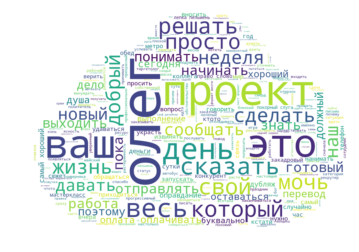

In [11]:
def make_cloud():
    with open('texts_mystem.txt', 'r', encoding="utf-8") as f:
        text = f.read()
    comment_mask = np.array(Image.open("cloud.jpg"))
    cloud = WordCloud(background_color="white", max_words=300,
                      mask=comment_mask)
    cloud.generate(text)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    cloud.to_file("lemm_cloud.png")
    plt.show()

make_cloud()
